In [1]:
import os
import sys
import torch as tf
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Magic trick from https://piazza.com/class/kyipdksfp9q1dn?cid=271_f1
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from tops.config import instantiate, LazyConfig
from ssd import utils
from tqdm import tqdm
from dataset_exploration.analyze_stuff import get_config, get_dataloader, analyze_something

In [2]:
config_path = "/home/viljamiu/SSD/configs/tdt4265.py"
cfg = get_config(config_path)
dataset_to_analyze = "train"  # or "val"
dataloader = get_dataloader(cfg, dataset_to_analyze)
dataloader_val = get_dataloader(cfg, "val")

NOTE! Installing ujson may make loading annotations faster.
It looks like you are currently working on the server, with a 'working directory' in: /work/snotra/viljamiu
	If you struggle with NTNU home directory becoming full, we recommend you to change the output directory to: /work/snotra/viljamiu
	 /work/snotra/viljamiu does not sync with NTNU HOME, and is a directory only located on the server.
	 To change the output directory of SSD, set save_in_work to True in the file configs/utils.py, in the function get_output_dir.
Saving SSD outputs to: outputs/
Found dataset directory in: /work/datasets/mnist_object_detection/train
Found dataset directory in: /work/datasets/mnist_object_detection/val
Found dataset directory in: /work/datasets/tdt4265_2022
Found dataset file in: /work/datasets/tdt4265_2022/train_annotations.json
Found dataset directory in: /work/datasets/tdt4265_2022
Found dataset file in: /work/datasets/tdt4265_2022/val_annotations.json


/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Cluster ground truth bounding boxes into 20 clusters
to be used as the target bounding boxes, when designing anchor boxes

In [3]:
def box_sizes(dataloader, set_name):
    box_df = pd.DataFrame({'w': [], 'h': [], 'label': [], 'label_name': [], 'set': []})

    for image in dataloader:
        boxes = image["boxes"][0].tolist()
        labels = image["labels"][0].tolist()
        
        for i, box in enumerate(boxes):
            # box == [xmin ymin xmax ymax]
            lab = labels[i]
            w = (box[2]-box[0])*1024
            h = (box[3]-box[1])*128
            df = pd.DataFrame({'w': [w], 'h': [h], 'label': [int(lab)], 'label_name': [cfg.label_map[int(lab)]], 'set': [set_name]})
            
            box_df = box_df.append(df, ignore_index = True)
        
    return box_df

train_box = box_sizes(dataloader, "train")
val_box = box_sizes(dataloader_val, "val")

In [4]:
all_boxes = train_box.append(val_box, ignore_index = True)
all_boxes.head()

,w,h,label,label_name,set
0,13.780029,56.080002,7.0,person,train
1,12.580017,33.750000,6.0,scooter,train
2,14.030029,36.620003,6.0,scooter,train
3,5.779968,8.190002,1.0,car,train
4,7.940000,12.700001,1.0,car,train


In [5]:
# Clustering to 20 clusters
x = all_boxes.iloc[:,0:2]
kmeans = KMeans(20)
kmeans.fit(x)
centers = kmeans.cluster_centers_.astype(int)
centers[centers[:, 0].argsort()]

array([[  5,  11],
       [  6,  21],
       [  8,  31],
       [ 10,  42],
       [ 12,  53],
       [ 14,  13],
       [ 19,  21],
       [ 20,  72],
       [ 27,  31],
       [ 29,  51],
       [ 43,  44],
       [ 65,  34],
       [ 71,  93],
       [ 81,  54],
       [100,  28],
       [127, 117],
       [137,  53],
       [181,  67],
       [213, 124],
       [354, 127]])

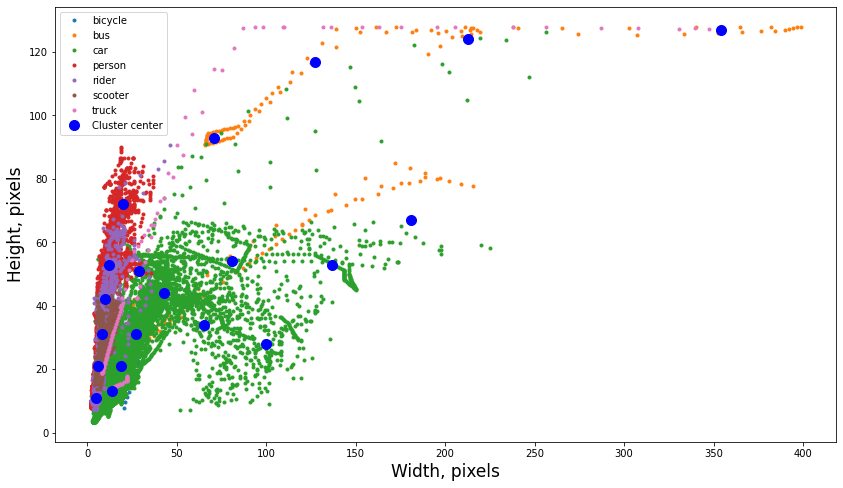

In [8]:
groups = all_boxes.groupby('label_name')

fig, ax = plt.subplots()

fig.set_size_inches(14, 8)
for name, group in groups:
    ax.plot(group.w, group.h, marker='o', linestyle='', ms=3, label=name)
    
ax.plot(centers[:,0], centers[:,1], marker='o', linestyle='', ms=10, label="Cluster center", c="blue")
ax.legend()
plt.ylabel('Height, pixels',size=17)
plt.xlabel('Width, pixels',size=17)
plt.savefig("bb_clusters.pdf")